In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import old_functions as old_func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
data = old_func.read_hist_models('/g/data/lp01/CMIP6/CMIP/', '/historical/r1i1p1f1/Amon/pr/gr1.5/').pr.sel(time=slice('1900-01', '2014-12')).chunk('auto')
data = data.sortby('model')

In [ ]:
# Select out the 20 models we are using (no pr for KIOST in lp01 or oi10)
keep = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'EC-Earth3', 'EC-Earth3-Veg', 'FGOALS-g3',
        'GFDL-CM4', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G', 'MIROC6', 'MPI-ESM1-2-HR',
        'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM']

data = data.sel(model=keep)*86400 # convert to mm/day

In [ ]:
# Calculate anomalies 
clims = data.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anoms = (data.groupby('time.month') - clims).chunk('auto')

In [ ]:
# Take DJF average
quarterly_anoms = anoms.resample(time='QS-DEC').mean('time')
djf_anoms = quarterly_anoms.isel(time=slice(0,None,4))

In [ ]:
# NINO indices 
EP = xr.open_dataarray('/g/data/w40/rl5183/EP_nino_cmip6_20.nc')
CP = xr.open_dataarray('/g/data/w40/rl5183/CP_nino_cmip6_20.nc')

In [ ]:
EP = EP.drop_sel(model='KIOST-ESM')
CP = CP.drop_sel(model='KIOST-ESM')

In [ ]:
# Take DJF average of EP index and CP index
quarterly_EP = EP.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))

quarterly_CP = CP.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))

In [ ]:
djf_anoms.to_netcdf('/g/data/w40/rl5183/temp_file')

In [ ]:
djf_anoms = xr.open_dataarray('/g/data/w40/rl5183/temp_file')

In [ ]:
EP_regress_list = []
CP_regress_list = []
for m in djf_anoms.model:
    EP_regress_list.append(func.regress_nino(djf_anoms.sel(model=m).drop_sel(time='1899-12'), djf_EP.sel(model=m).drop_sel(time='1899-12')))
    CP_regress_list.append(func.regress_nino(djf_anoms.sel(model=m).drop_sel(time='1899-12'), djf_CP.sel(model=m).drop_sel(time='1899-12')))

In [ ]:
EP_regressions = xr.concat(EP_regress_list, dim='model')
CP_regressions = xr.concat(CP_regress_list, dim='model')

In [ ]:
EP_regressions.to_netcdf('/g/data/w40/rl5183/CMIP6_20_EP_pr_regressions')
CP_regressions.to_netcdf('/g/data/w40/rl5183/CMIP6_20_CP_pr_regressions')

In [2]:
EP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_EP_pr_regressions')
CP_regressions = xr.open_dataarray('/g/data/w40/rl5183/CMIP6_20_CP_pr_regressions')

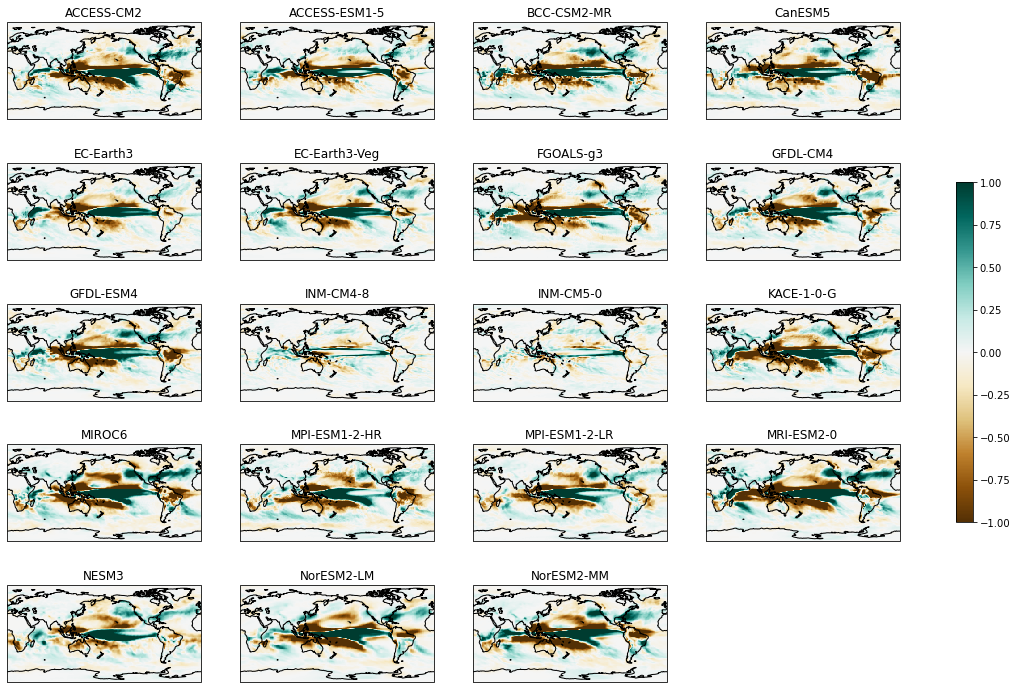

In [3]:
fig = plt.figure(figsize=(20,12.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(EP_regressions.model):
    # Plot 
    d = EP_regressions.sel(model=m)
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    C = d.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, cmap='BrBG', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

#plt.savefig('CMIP6_EP_glob_pr_pattern_NINO', bbox_inches='tight', dpi=300)

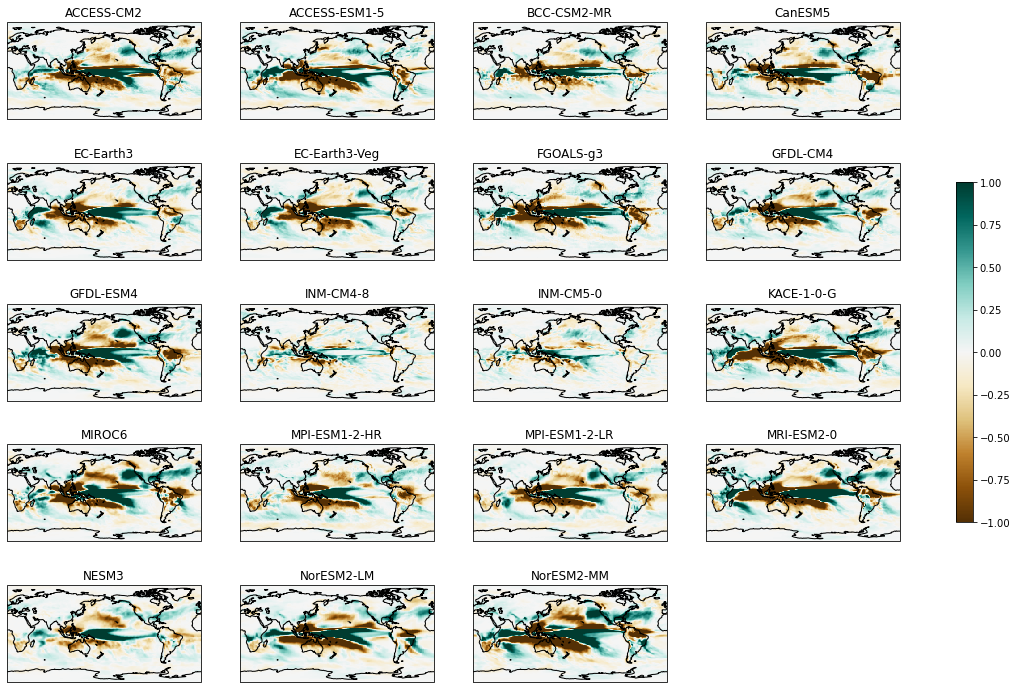

In [4]:
fig = plt.figure(figsize=(20,12.5))
axs = []

columns = 4
rows = 5

for i, m in enumerate(CP_regressions.model):
    # Plot 
    d = CP_regressions.sel(model=m)
    ax = fig.add_subplot(rows, columns, i+1, projection=ccrs.PlateCarree(180))
    C = d.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, cmap='BrBG', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(f'{m.data}')
    # Gather all axes for when we make the colour bar
    axs.append(ax)
    
# Put the colour bar to the left of all axes
cbar = plt.colorbar(C, ax=axs, shrink=0.5)

#plt.savefig('CMIP6_CP_glob_pr_pattern_NINO', bbox_inches='tight', dpi=300)

#### Pattern Correlations

In [3]:
# Read in the 20CR precip
precip = xr.open_dataarray('/g/data/w40/rl5183/20CR_pr_ensemble_mean_1.5x1.5.nc').sel(time=slice('1900-01', '2014-12'))*86400
# Calculate anomalies
clim = precip.sel(time=slice('1979-01', '2008-12')).groupby('time.month').mean()
anom = (precip.groupby('time.month') - clim)
# Take DJF average
quarterly_anom = anom.resample(time='QS-DEC').mean('time')
djf_anom = quarterly_anom.isel(time=slice(0,None,4))
# NINO indices from Hadisst
sst = xr.open_dataset('/g/data/w40/rl5183/hadisst.1870_2017_1.5x1.5.nc').sst
# Detrend 
sst_detrend = np.apply_along_axis(func.quad_detrend, 0, sst)
sst_dt = xr.DataArray(sst_detrend, coords=sst.coords, attrs=sst.attrs)
# Calculate EP and CP index
nino3 = func.nino3_index(sst_dt, '1979-01', '2008-12')
nino4 = func.nino4_index(sst_dt, '1979-01', '2008-12')
# Calculate EP and CP index
EP_sst = (nino3 - 0.5*nino4).sel(time=slice('1900-01', '2014-12'))
CP_sst = (nino4 - 0.5*nino3).sel(time=slice('1900-01', '2014-12'))
# Take DJF average of EP index and CP index
quarterly_EP = EP_sst.resample(time='QS-DEC').mean('time')
djf_EP = quarterly_EP.isel(time=slice(0,None,4))

quarterly_CP = CP_sst.resample(time='QS-DEC').mean('time')
djf_CP = quarterly_CP.isel(time=slice(0,None,4))
# Regression
EP_regress_20CR = func.regress_nino(djf_anom, djf_EP)
CP_regress_20CR = func.regress_nino(djf_anom, djf_CP)

In [4]:
def group_by_lat(data, regions):
    data_by_lat = []
    for reg_name,reg_loc in regions.items():
        data_sliced = data.sel(lat=reg_loc).rename(reg_name)
        data_by_lat.append(data_sliced)
    data_by_lat = xr.merge(data_by_lat)
    return data_by_lat

In [5]:
# Define the regions
regions = {
    "Tropics":slice(-23.5,23.5),
    "Subtropics_NH":slice(23.5,35.5),
    "Subtropics_SH":slice(-35.5, -23.5),
    "Mid_latitudes_NH":slice(35.5, 66.5),
    "Mid_latitudes_SH":slice(-66.5, -35.5),
}

In [6]:
EP_grouped_20CR = group_by_lat(EP_regress_20CR, regions)
CP_grouped_20CR = group_by_lat(CP_regress_20CR, regions)

In [7]:
EP_grouped = []
for m in EP_regressions.model:
    EP_grouped.append(group_by_lat(EP_regressions.sel(model=m), regions))
EP_grouped = xr.concat(EP_grouped, dim='model')

In [8]:
CP_grouped = []
for m in CP_regressions.model:
    CP_grouped.append(group_by_lat(CP_regressions.sel(model=m), regions))
CP_grouped = xr.concat(CP_grouped, dim='model')

In [9]:
Tropics_cor_EP = []
for m in EP_grouped.model:
    Tropics_cor_EP.append(func.pattern_cor(EP_grouped.Tropics.sel(model=m), EP_grouped_20CR.Tropics))
    
Sub_NH_cor_EP = []
for m in EP_grouped.model:
    Sub_NH_cor_EP.append(func.pattern_cor(EP_grouped.Subtropics_NH.sel(model=m), EP_grouped_20CR.Subtropics_NH))
    
Sub_SH_cor_EP = []
for m in EP_grouped.model:
    Sub_SH_cor_EP.append(func.pattern_cor(EP_grouped.Subtropics_SH.sel(model=m), EP_grouped_20CR.Subtropics_SH))
    
Mid_NH_cor_EP = []
for m in EP_grouped.model:
    Mid_NH_cor_EP.append(func.pattern_cor(EP_grouped.Mid_latitudes_NH.sel(model=m), EP_grouped_20CR.Mid_latitudes_NH))
    
Mid_SH_cor_EP = []
for m in EP_grouped.model:
    Mid_SH_cor_EP.append(func.pattern_cor(EP_grouped.Mid_latitudes_SH.sel(model=m), EP_grouped_20CR.Mid_latitudes_SH))

In [10]:
Tropics_cor_CP = []
for m in CP_grouped.model:
    Tropics_cor_CP.append(func.pattern_cor(CP_grouped.Tropics.sel(model=m), CP_grouped_20CR.Tropics))
    
Sub_NH_cor_CP = []
for m in CP_grouped.model:
    Sub_NH_cor_CP.append(func.pattern_cor(CP_grouped.Subtropics_NH.sel(model=m), CP_grouped_20CR.Subtropics_NH))
    
Sub_SH_cor_CP = []
for m in CP_grouped.model:
    Sub_SH_cor_CP.append(func.pattern_cor(CP_grouped.Subtropics_SH.sel(model=m), CP_grouped_20CR.Subtropics_SH))
    
Mid_NH_cor_CP = []
for m in CP_grouped.model:
    Mid_NH_cor_CP.append(func.pattern_cor(CP_grouped.Mid_latitudes_NH.sel(model=m), CP_grouped_20CR.Mid_latitudes_NH))
    
Mid_SH_cor_CP = []
for m in CP_grouped.model:
    Mid_SH_cor_CP.append(func.pattern_cor(CP_grouped.Mid_latitudes_SH.sel(model=m), CP_grouped_20CR.Mid_latitudes_SH))

In [12]:
# Make pandas dataframe 
model_names = EP_regressions.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], Tropics_cor_EP[i], Sub_NH_cor_EP[i], Sub_SH_cor_EP[i], Mid_NH_cor_EP[i], Mid_SH_cor_EP[i]]
    pandas_data.append(cell)
    
EP_df = pd.DataFrame(pandas_data, columns=['Model', 'Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'])
EP_df.head()

,Model,Tropics,Sub Tropics NH,Sub Tropics SH,Mid Lats NH,Mid Lats SH
0,ACCESS-CM2,0.783407,0.835369,0.805783,0.499004,0.497648
1,ACCESS-ESM1-5,0.635596,0.620583,0.592369,0.371746,0.513447
2,BCC-CSM2-MR,0.615785,0.508474,0.603928,0.433040,0.461452
3,CanESM5,0.577271,0.597075,0.569875,0.492067,0.614560
4,EC-Earth3,0.761755,0.775078,0.769532,0.523107,0.356134


Text(0.5, 1.0, 'EP PRECIP NINO')

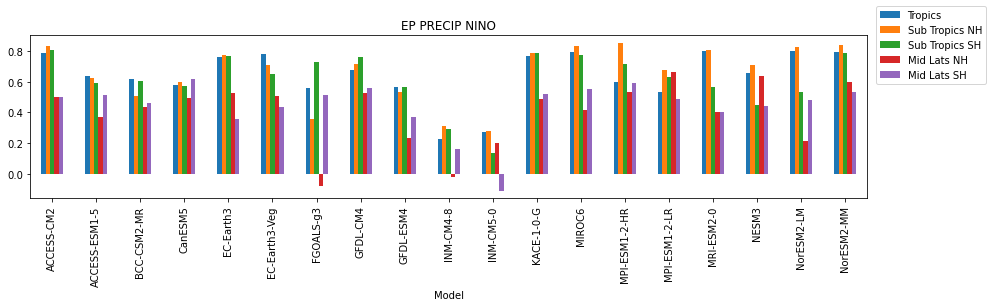

In [12]:
EP_df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
plt.title('EP PRECIP NINO')

Text(0.5, 1.0, 'EP Precip NINO')

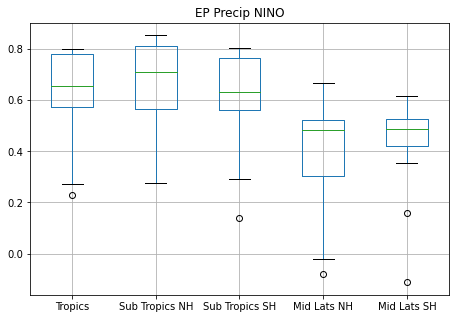

In [19]:
EP_df.boxplot(column=['Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'], figsize=(7.5,5))
plt.title('EP Precip NINO')

In [13]:
# Make pandas dataframe 
model_names = CP_regressions.model.values
names = list(model_names)

pandas_data = []
for i in np.arange(0,len(names)):
    cell = [names[i], Tropics_cor_CP[i], Sub_NH_cor_CP[i], Sub_SH_cor_CP[i], Mid_NH_cor_CP[i], Mid_SH_cor_CP[i]]
    pandas_data.append(cell)
    
CP_df = pd.DataFrame(pandas_data, columns=['Model', 'Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'])
CP_df.head()

,Model,Tropics,Sub Tropics NH,Sub Tropics SH,Mid Lats NH,Mid Lats SH
0,ACCESS-CM2,0.761508,0.791660,0.792911,0.644033,0.552688
1,ACCESS-ESM1-5,0.605582,0.551674,0.724176,0.369919,0.514784
2,BCC-CSM2-MR,0.608025,0.600714,0.545259,0.313100,0.506680
3,CanESM5,0.585958,0.670815,0.404622,0.504664,0.531110
4,EC-Earth3,0.775850,0.625413,0.546288,0.412067,0.138283


Text(0.5, 1.0, 'CP PRECIP NINO')

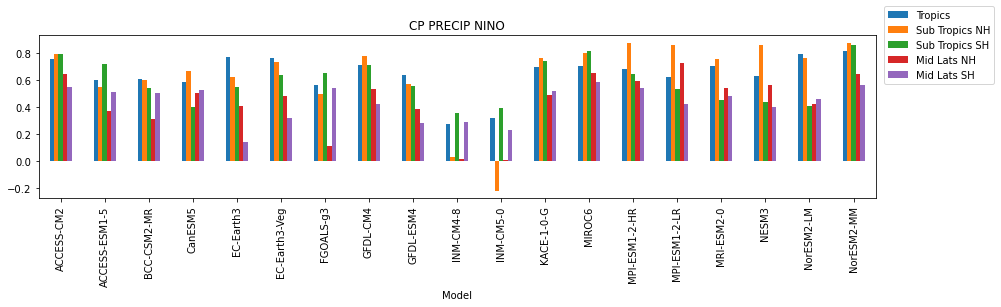

In [15]:
CP_df.plot(x='Model', kind='bar', stacked=False, figsize=(15,3))
plt.legend(loc=(1.01,0.7))
plt.title('CP PRECIP NINO')

Text(0.5, 1.0, 'CP PRECIP NINO')

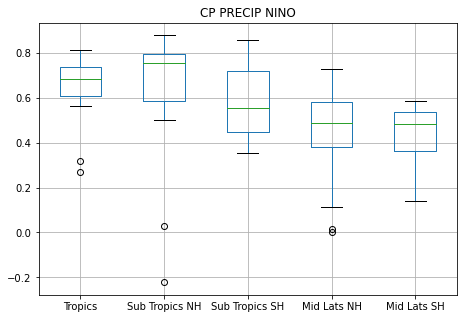

In [17]:
CP_df.boxplot(column=['Tropics', 'Sub Tropics NH', 'Sub Tropics SH', 'Mid Lats NH', 'Mid Lats SH'], figsize=(7.5,5))
plt.title('CP PRECIP NINO')

Text(0, 0.5, 'CP')

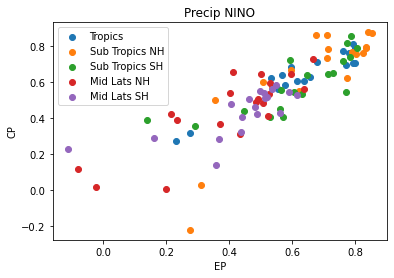

In [18]:
plt.scatter(EP_df['Tropics'], CP_df['Tropics'], label='Tropics')
plt.scatter(EP_df['Sub Tropics NH'], CP_df['Sub Tropics NH'], label='Sub Tropics NH')
plt.scatter(EP_df['Sub Tropics SH'], CP_df['Sub Tropics SH'], label='Sub Tropics SH')
plt.scatter(EP_df['Mid Lats NH'], CP_df['Mid Lats NH'], label='Mid Lats NH')
plt.scatter(EP_df['Mid Lats SH'], CP_df['Mid Lats SH'], label='Mid Lats SH')
plt.title('Precip NINO')
plt.legend()
plt.xlabel('EP')
plt.ylabel('CP')

In [11]:
%store -r had_EP_sst_nino
%store -r had_CP_sst_nino

In [14]:
# remove model KIOST index 12
del had_EP_sst_nino[12]
del had_CP_sst_nino[12]

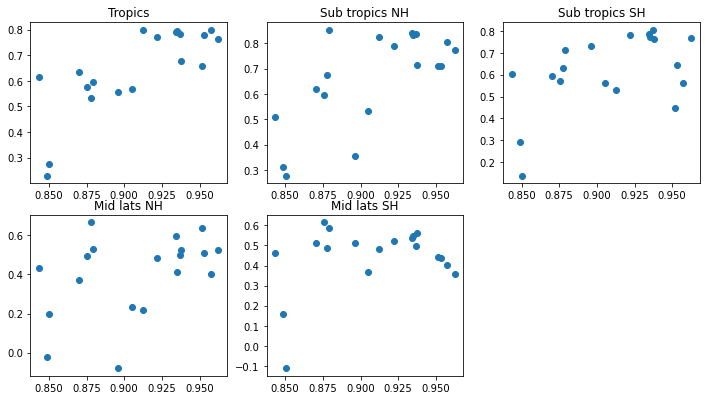

In [15]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(2,3,1)
ax.scatter(had_EP_sst_nino, Tropics_cor_EP)
ax.title.set_text('Tropics')
ax = fig.add_subplot(2,3,2)
ax.scatter(had_EP_sst_nino, Sub_NH_cor_EP)
ax.title.set_text('Sub tropics NH')
ax = fig.add_subplot(2,3,3)
ax.scatter(had_EP_sst_nino, Sub_SH_cor_EP)
ax.title.set_text('Sub tropics SH')
ax = fig.add_subplot(2,3,4)
ax.scatter(had_EP_sst_nino, Mid_NH_cor_EP)
ax.title.set_text('Mid lats NH')
ax = fig.add_subplot(2,3,5)
ax.scatter(had_EP_sst_nino, Mid_SH_cor_EP)
ax.title.set_text('Mid lats SH')

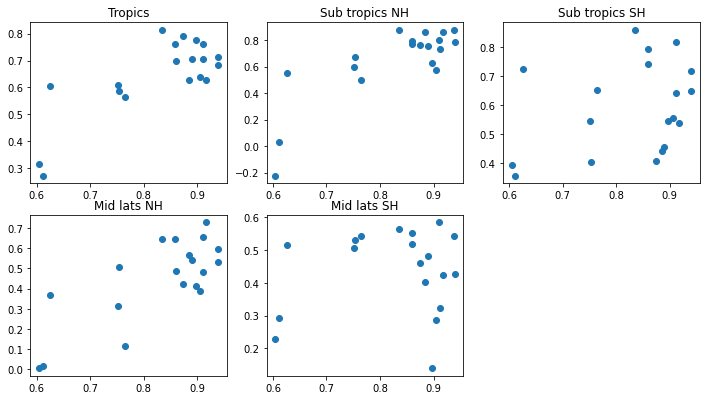

In [16]:
fig = plt.figure(figsize=(12,6.5))
ax = fig.add_subplot(2,3,1)
ax.scatter(had_CP_sst_nino, Tropics_cor_CP)
ax.title.set_text('Tropics')
ax = fig.add_subplot(2,3,2)
ax.scatter(had_CP_sst_nino, Sub_NH_cor_CP)
ax.title.set_text('Sub tropics NH')
ax = fig.add_subplot(2,3,3)
ax.scatter(had_CP_sst_nino, Sub_SH_cor_CP)
ax.title.set_text('Sub tropics SH')
ax = fig.add_subplot(2,3,4)
ax.scatter(had_CP_sst_nino, Mid_NH_cor_CP)
ax.title.set_text('Mid lats NH')
ax = fig.add_subplot(2,3,5)
ax.scatter(had_CP_sst_nino, Mid_SH_cor_CP)
ax.title.set_text('Mid lats SH')

#### Do models with better temp teleconnection also have better precip teleconnection? 

In [11]:
%store -r EP_temp
%store -r CP_temp

In [21]:
# Remove KIOST
EP_temp = EP_temp.drop(12)
CP_temp = CP_temp.drop(12)

Text(0, 0.5, 'Precip')

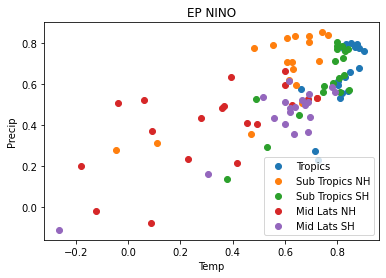

In [23]:
plt.scatter(EP_temp['Tropics'], EP_df['Tropics'], label='Tropics')
plt.scatter(EP_temp['Sub Tropics NH'], EP_df['Sub Tropics NH'], label='Sub Tropics NH')
plt.scatter(EP_temp['Sub Tropics SH'], EP_df['Sub Tropics SH'], label='Sub Tropics SH')
plt.scatter(EP_temp['Mid Lats NH'], EP_df['Mid Lats NH'], label='Mid Lats NH')
plt.scatter(EP_temp['Mid Lats SH'], EP_df['Mid Lats SH'], label='Mid Lats SH')
plt.title('EP NINO')
plt.legend()
plt.xlabel('Temp')
plt.ylabel('Precip')

Text(0, 0.5, 'Precip')

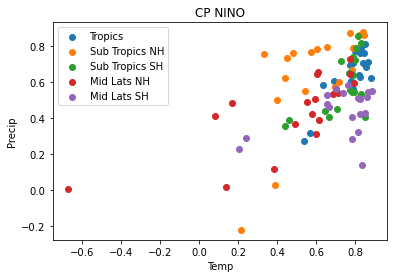

In [24]:
plt.scatter(CP_temp['Tropics'], CP_df['Tropics'], label='Tropics')
plt.scatter(CP_temp['Sub Tropics NH'], CP_df['Sub Tropics NH'], label='Sub Tropics NH')
plt.scatter(CP_temp['Sub Tropics SH'], CP_df['Sub Tropics SH'], label='Sub Tropics SH')
plt.scatter(CP_temp['Mid Lats NH'], CP_df['Mid Lats NH'], label='Mid Lats NH')
plt.scatter(CP_temp['Mid Lats SH'], CP_df['Mid Lats SH'], label='Mid Lats SH')
plt.title('CP NINO')
plt.legend()
plt.xlabel('Temp')
plt.ylabel('Precip')